In [27]:
DATASET_PATH = 'D:\Work\computerVision\Datasets\WebMarket'
IMAGE_PATH = 'db1/db1/db1/db102.jpg'
TRAIN_SPLIT_PCNTG = 0.7
VALIDATION_SPLIT_PCNTG = 0.15
#TEST_SPLIT_PCNTG = 0.15 # Left of above 2, thus not used

In [74]:
import os
import pandas as pd

import torch
from torch.utils.data import Dataset,DataLoader
from torchvision.io import read_image
from sklearn.preprocessing import LabelEncoder

from torchvision.models.detection import fcos_resnet50_fpn
from torchvision.models.detection.fcos import FCOSHead

from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import v2 as T
from engine import train_one_epoch, evaluate
import utils

from torchvision.utils import draw_bounding_boxes
from matplotlib import pyplot as plt

import random

In [75]:
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

Text(0.5, 1.0, 'Displaying image db231.jpg')

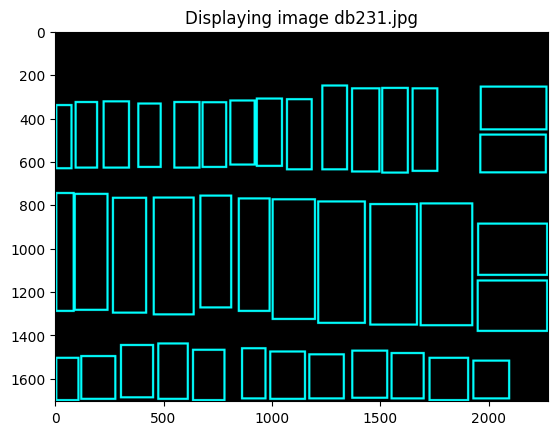

In [90]:
class WebMarket(Dataset):
    def __init__(self,dataset_path,transformation):
        self.dataset_path = dataset_path
        self.transformation = transformation
        self.annotation = pd.read_csv(os.path.join(DATASET_PATH,'db1_data.csv'))
        
        self.img_dir = 'db1/db1/db1'
        self.meta = os.listdir(os.path.join(self.dataset_path,self.img_dir))
        self.meta.sort()
        
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.annotation['class'])
        self.annotation['class'] = self.label_encoder.transform(self.annotation['class'])

        self.num_classes = self.annotation['class'].nunique()+1
        self.max_dets = self.annotation.groupby(['filename']).xmin.count().max()

    def __len__(self):
        return len(self.meta)

    def __getitem__(self,idx):
        img_name = self.meta[idx]
        img = read_image(os.path.join(self.dataset_path, self.img_dir, img_name))
        
        annotation = self.annotation[self.annotation['filename']==img_name]
        bboxes = torch.tensor(annotation[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy())
        labels = annotation['class'].values
        annotation = {
            'boxes': bboxes,
            'labels': labels,
            'image_id': int(img_name[2:-4])
        }
        
        if self.transformation is not None:
            img, annotation = self.transformation(img, annotation)
            
        return img,annotation
    
webMarket = WebMarket(DATASET_PATH,transformation=get_transform(train=False))

random.seed(2048)
rand_id = random.randint(0, len(webMarket))
img,annots = webMarket[rand_id]
plt.imshow(draw_bounding_boxes(img.to(torch.uint8), annots['boxes'], colors='cyan', width=10).permute(1,2,0))
plt.title(f'Displaying image db{annots["image_id"]}.jpg')

In [91]:
sampler = list(range(0,300))
random.seed(2048)
random.shuffle(sampler)

train_sampler = sampler[:int(len(webMarket)*TRAIN_SPLIT_PCNTG)]
validation_sampler = sampler[len(train_sampler) : len(train_sampler) + int(len(webMarket)*VALIDATION_SPLIT_PCNTG)]
test_sampler = sampler[len(train_sampler) + len(validation_sampler): ]

train_data_loader = DataLoader(webMarket, batch_size=4, sampler=train_sampler, collate_fn=utils.collate_fn)
validation_data_loader = DataLoader(webMarket, batch_size=4, sampler=validation_sampler, collate_fn=utils.collate_fn)
test_data_loader = DataLoader(webMarket, batch_size=4, sampler=test_sampler, collate_fn=utils.collate_fn)

In [92]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'{device} available for training.')

cuda available for training.


In [93]:
model = fcos_resnet50_fpn(weights='DEFAULT')
model.head = FCOSHead(in_channels=model.backbone.out_channels,num_anchors=webMarket.max_dets, num_classes=webMarket.num_classes)
model.to(device)

FCOS(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=1e

In [94]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 5

In [95]:
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.